# Stock Price Prediction using LSTM (Enhanced)

This notebook builds an enhanced LSTM model for predicting stock prices.

**Key improvements over the original model:**

- MinMaxScaler normalization for stable training
- Sliding window (step=1) for more training samples
- Dropout layers to prevent overfitting
- Linear output activation (appropriate for regression)
- ReduceLROnPlateau + EarlyStopping callbacks
- Reduced LSTM units to combat overfitting


In [2]:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")


TensorFlow version: 2.20.0


In [3]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')


## 1. Load Data


In [5]:
AAPL = pd.read_csv("../dataset/Pre_Processed_AAPL.csv")
TSLA = pd.read_csv("../dataset/Pre_Processed_TSLA.csv")
GOOG = pd.read_csv("../dataset/Pre_Processed_GOOG.csv")
MSFT = pd.read_csv("../dataset/Pre_Processed_MSFT.csv")
AMZN = pd.read_csv("../dataset/Pre_Processed_AMZN.csv")


In [ ]:
AAPL.info()


<class 'pandas.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   str    
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), str(1)
memory usage: 84.8 KB


## 2. Data Preparation

**Improvements:**

- **MinMaxScaler**: Normalizes data to [0, 1] for stable training
- **Sliding Window (step=1)**: Creates overlapping sequences for many more training samples
- **Window size = 5**: Uses 5 past days to predict the next 5 days


In [6]:
def Dataset(Data, Date, window_size=5):
  """Creates training and testing datasets with sliding window (step=1).
  
  Improvements over original:
  - Uses MinMaxScaler for normalization
  - Sliding window with step=1 (much more training data)
  - Returns the scaler for inverse transformation
  """
  Data['Date'] = pd.to_datetime(Data['Date'])
  
  # Split by date
  train_data = Data['Adj. Close'][Data['Date'] < Date].to_numpy().reshape(-1, 1)
  test_data = Data['Adj. Close'][Data['Date'] >= Date].to_numpy().reshape(-1, 1)
  
  # Fit scaler on training data only
  scaler = MinMaxScaler(feature_range=(0, 1))
  train_scaled = scaler.fit_transform(train_data)
  test_scaled = scaler.transform(test_data)
  
  def create_sequences(data, window_size):
    X, Y = [], []
    for i in range(len(data) - 2 * window_size + 1):  # sliding window, step=1
      X.append(data[i : i + window_size])
      Y.append(data[i + window_size : i + 2 * window_size])
    return np.array(X), np.array(Y)
  
  Train_X, Train_Y = create_sequences(train_scaled, window_size)
  Test_X, Test_Y = create_sequences(test_scaled, window_size)
  
  print(f"Training samples: {len(Train_X)}, Test samples: {len(Test_X)}")
  print(f"Train X shape: {Train_X.shape}, Train Y shape: {Train_Y.shape}")
  
  return Train_X, Train_Y, Test_X, Test_Y, scaler


## 3. Enhanced Model Architecture

**Changes from original:**

| Original                           | Enhanced                                 |
| ---------------------------------- | ---------------------------------------- |
| LSTM(200) + LSTM(200)              | LSTM(128) + LSTM(64)                     |
| No Dropout                         | Dropout(0.2) after each LSTM             |
| Dense(200→100→50→5) all leaky_relu | Dense(64→32→5) with relu + linear output |
| 548K params (prone to overfit)     | ~100K params (better generalization)     |
| Custom LR warmup/decay             | ReduceLROnPlateau + EarlyStopping        |


In [ ]:
def Model(window_size=5):
  """Enhanced LSTM model with dropout and proper output activation."""
  model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(window_size, 1), return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(window_size)  # Linear activation for regression
  ])
  return model


In [41]:
def Model_V2(window_size=5):
    """Enhanced LSTM model with stronger regularization to prevent overfitting."""
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, input_shape=(window_size, 1), return_sequences=True,
                             kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(32, return_sequences=False,
                             kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(window_size)  # Linear activation for regression
    ])
    return model


In [ ]:
def Model_V3():
  model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 1), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
  return model


In [ ]:
model = Model()
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 5, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,373 (478.02 KB)

 Trainable params: 122,373 (478.02 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Callbacks Configuration

Using `ReduceLROnPlateau` and `EarlyStopping` instead of the manual warmup/decay schedule.


In [37]:
from keras.src.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=15,
    min_lr=1e-7,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'TSLA.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


## 5. Train the AAPL Model


In [30]:
AAPL_Date = '2020-10-01'
AAPL_Train_X, AAPL_Train_Y, AAPL_Test_X, AAPL_Test_Y, AAPL_scaler = Dataset(AAPL, AAPL_Date)


Training samples: 1438, Test samples: 93
Train X shape: (1438, 5, 1), Train Y shape: (1438, 5, 1)


In [31]:
AAPL_Model = Model()
AAPL_Model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)


In [32]:
AAPL_hist = AAPL_Model.fit(
    AAPL_Train_X, AAPL_Train_Y,
    epochs=100,
    batch_size=32,
    validation_data=(AAPL_Test_X, AAPL_Test_Y),
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)


Epoch 1/100
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0462 - root_mean_squared_error: 0.2123
Epoch 1: val_loss did not improve from 0.01410
45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - loss: 0.0254 - root_mean_squared_error: 0.1594 - val_loss: 0.0170 - val_root_mean_squared_error: 0.1304 - learning_rate: 0.0010
Epoch 2/100
43/45 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0017 - root_mean_squared_error: 0.0408
Epoch 2: val_loss improved from 0.01410 to 0.00253, saving model to AAPL.keras

Epoch 2: finished saving model to AAPL.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0014 - root_mean_squared_error: 0.0376 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0503 - learning_rate: 0.0010
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0012 - root_mean_squared_error: 0.0348
Epoch 3: val_loss improved from 0.00253 to 0.00211, saving model to AAPL.keras

Epoch 3: finished saving model to AAPL.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0010 - ro

## 6. Training History Visualization


In [33]:
history_dict = AAPL_hist.history

loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
rmse = history_dict["root_mean_squared_error"]
val_rmse = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)


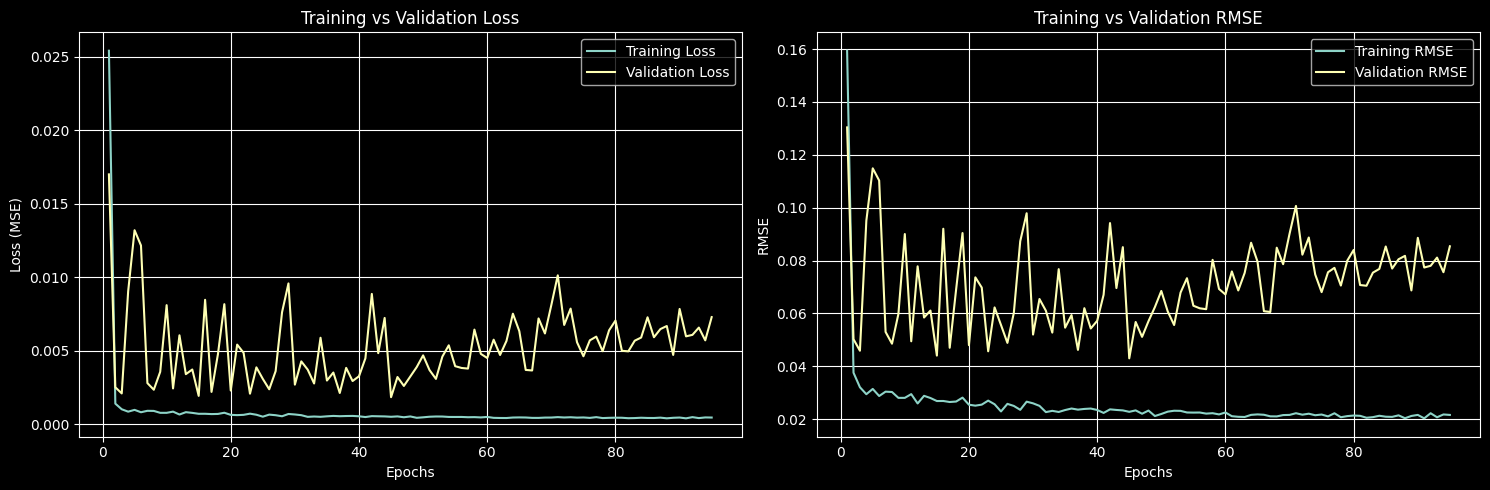

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label='Training Loss')
ax1.plot(epochs, val_loss, label='Validation Loss')
ax1.set(xlabel="Epochs", ylabel="Loss (MSE)")
ax1.set_title("Training vs Validation Loss")
ax1.legend()
ax1.grid(True)

ax2.plot(epochs, rmse, label="Training RMSE")
ax2.plot(epochs, val_rmse, label="Validation RMSE")
ax2.set(xlabel="Epochs", ylabel="RMSE")
ax2.set_title("Training vs Validation RMSE")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


## 7. Evaluation on Test Set

Predictions are inverse-transformed back to original price scale for meaningful error metrics.


In [35]:
# Make predictions (scaled)
predictions_scaled = AAPL_Model.predict(AAPL_Test_X)

# Inverse transform to original scale
predictions = AAPL_scaler.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()
actuals = AAPL_scaler.inverse_transform(AAPL_Test_Y.reshape(-1, 1)).flatten()

# Calculate metrics on original scale
mse = mean_squared_error(actuals, predictions)
rmse_val = np.sqrt(mse)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f"\n{'='*50}")
print(f"LSTM Model - Test Set Evaluation (Original Scale)")
print(f"{'='*50}")
print(f"Root Mean Squared Error (RMSE): {rmse_val:.4f}")
print(f"Mean Absolute Error (MAE):      {mae:.4f}")
print(f"R² Score:                        {r2:.4f}")
print(f"{'='*50}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 625ms/step

LSTM Model - Test Set Evaluation (Original Scale)
Root Mean Squared Error (RMSE): 4.8451
Mean Absolute Error (MAE):      3.8368
R² Score:                        0.6621


## 8. Predictions Visualization


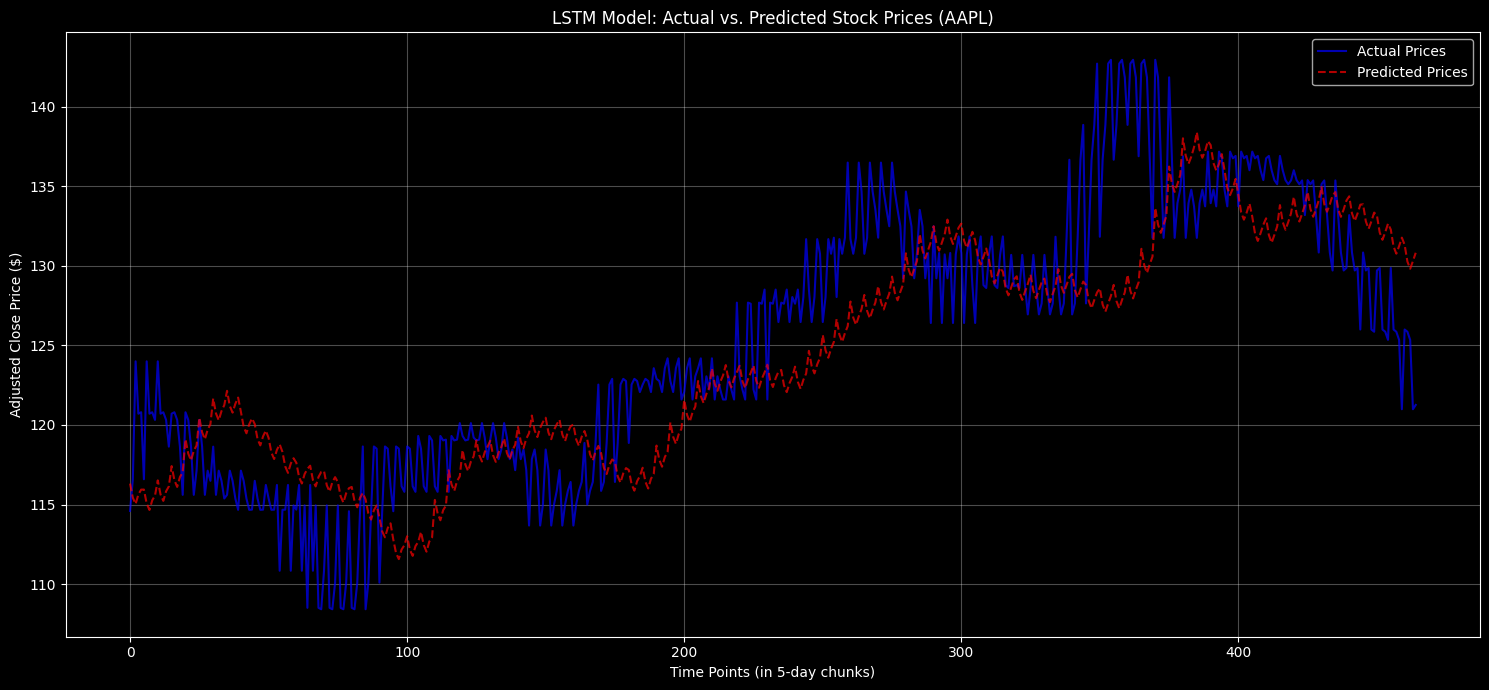

In [36]:
plt.figure(figsize=(15, 7))
plt.plot(actuals, color='blue', label='Actual Prices', alpha=0.7)
plt.plot(predictions, color='red', linestyle='--', label='Predicted Prices', alpha=0.7)
plt.title('LSTM Model: Actual vs. Predicted Stock Prices (AAPL)')
plt.xlabel('Time Points (in 5-day chunks)')
plt.ylabel('Adjusted Close Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Train the TSLA Model


In [10]:
TSLA.info()


<class 'pandas.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   str    
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), str(1)
memory usage: 84.8 KB


In [11]:
TSLA['Date'] = pd.to_datetime(TSLA['Date'])
TSLA.info()


<class 'pandas.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1549 non-null   datetime64[us]
 1   Open        1549 non-null   float64       
 2   High        1549 non-null   float64       
 3   Low         1549 non-null   float64       
 4   Close       1549 non-null   float64       
 5   Adj. Close  1549 non-null   float64       
 6   Volume      1549 non-null   float64       
dtypes: datetime64[us](1), float64(6)
memory usage: 84.8 KB


In [20]:
TSLA_Date = '2020-10-01'
TSLA_Train_X, TSLA_Train_Y, TSLA_Test_X, TSLA_Test_Y, TSLA_scaler = Dataset(TSLA, TSLA_Date)


Training samples: 1438, Test samples: 93
Train X shape: (1438, 5, 1), Train Y shape: (1438, 5, 1)


In [48]:
TSLA_Model = Model_V3()
TSLA_Model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)


In [49]:
TSLA_hist = TSLA_Model.fit(
    TSLA_Train_X, TSLA_Train_Y,
    epochs=100,
    batch_size=32,
    validation_data=(TSLA_Test_X, TSLA_Test_Y),
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)


Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0128 - root_mean_squared_error: 0.1118
Epoch 1: val_loss did not improve from 0.01606
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - loss: 0.0076 - root_mean_squared_error: 0.0871 - val_loss: 0.0211 - val_root_mean_squared_error: 0.1454 - learning_rate: 0.0010
Epoch 2/100
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0012 - root_mean_squared_error: 0.0344
Epoch 2: val_loss improved from 0.01606 to 0.01548, saving model to TSLA.keras

Epoch 2: finished saving model to TSLA.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 9.5187e-04 - root_mean_squared_error: 0.0309 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1244 - learning_rate: 0.0010
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 8.6633e-04 - root_mean_squared_error: 0.0294
Epoch 3: val_loss improved from 0.01548 to 0.01499, saving model to TSLA.keras

Epoch 3: finished saving model to TSLA.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 9.1

## Training History Visualization


In [44]:
history_dict = TSLA_hist.history

loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
rmse = history_dict["root_mean_squared_error"]
val_rmse = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)


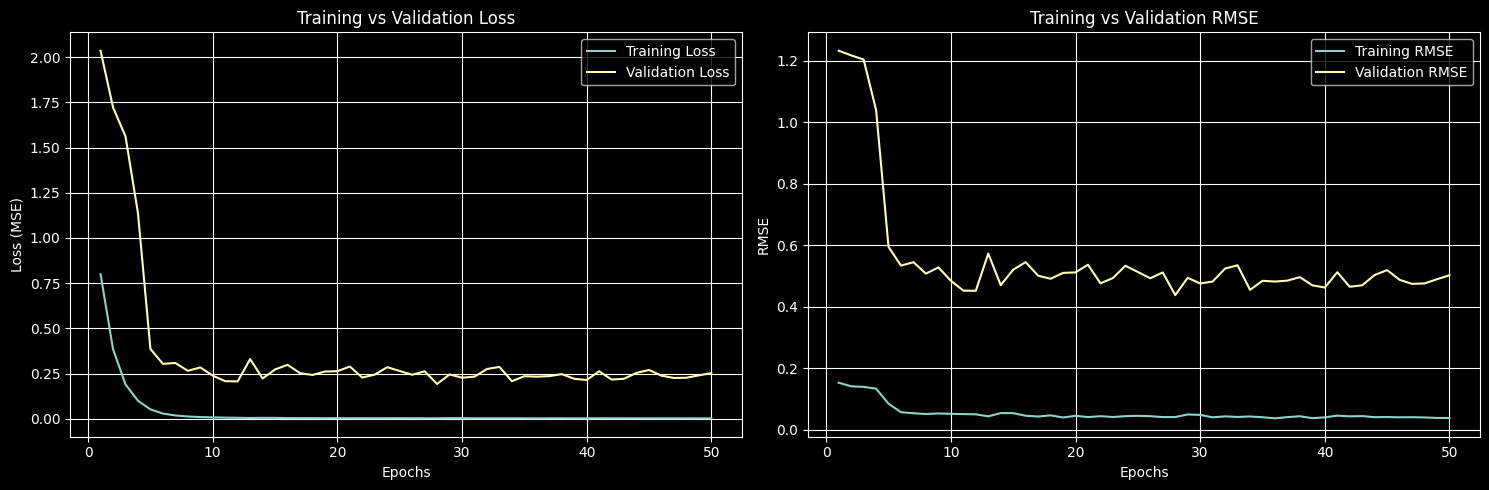

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label='Training Loss')
ax1.plot(epochs, val_loss, label='Validation Loss')
ax1.set(xlabel="Epochs", ylabel="Loss (MSE)")
ax1.set_title("Training vs Validation Loss")
ax1.legend()
ax1.grid(True)

ax2.plot(epochs, rmse, label="Training RMSE")
ax2.plot(epochs, val_rmse, label="Validation RMSE")
ax2.set(xlabel="Epochs", ylabel="RMSE")
ax2.set_title("Training vs Validation RMSE")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


## Evaluation on Test Set


In [46]:
# Make predictions (scaled)
predictions_scaled = TSLA_Model.predict(TSLA_Test_X)

# Inverse transform to original scale
predictions = TSLA_scaler.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()
actuals = TSLA_scaler.inverse_transform(TSLA_Test_Y.reshape(-1, 1)).flatten()

# Calculate metrics on original scale
mse = mean_squared_error(actuals, predictions)
rmse_val = np.sqrt(mse)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f"\n{'='*50}")
print(f"LSTM Model - Test Set Evaluation (Original Scale)")
print(f"{'='*50}")
print(f"Root Mean Squared Error (RMSE): {rmse_val:.4f}")
print(f"Mean Absolute Error (MAE):      {mae:.4f}")
print(f"R² Score:                        {r2:.4f}")
print(f"{'='*50}")


1/3 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000015921EEB920> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step

LSTM Model - Test Set Evaluation (Original Scale)
Root Mean Squared Error (RMSE): 578.5502
Mean Absolute Error (MAE):      554.7268
R² Score:                        -10.8353


## Predictions Visualization


In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(actuals, color='blue', label='Actual Prices', alpha=0.7)
plt.plot(predictions, color='red', linestyle='--', label='Predicted Prices', alpha=0.7)
plt.title('LSTM Model: Actual vs. Predicted Stock Prices (AAPL)')
plt.xlabel('Time Points (in 5-day chunks)')
plt.ylabel('Adjusted Close Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Linear Regression Model for Stock Price Prediction

A simple linear regression model is added for comparison with the LSTM models. This model uses the same pre-processed data and predicts the next day's price based on previous days.


In [52]:
# Linear Regression Model for AAPL
from sklearn.linear_model import LinearRegression

# Use the same window size as LSTM
window_size = 5

# Prepare features and targets for linear regression
# Predict next day's price using previous 'window_size' days
AAPL['Date'] = pd.to_datetime(AAPL['Date'])
AAPL_prices = AAPL['Adj. Close'].values

X_lr = []
Y_lr = []
for i in range(len(AAPL_prices) - window_size):
    X_lr.append(AAPL_prices[i:i+window_size])
    Y_lr.append(AAPL_prices[i+window_size])
X_lr = np.array(X_lr)
Y_lr = np.array(Y_lr)

# Split into train and test using the same date as LSTM
split_date = pd.to_datetime('2020-10-01')
dates = AAPL['Date'].values[window_size:]
train_idx = dates < split_date

test_idx = dates >= split_date

X_train_lr = X_lr[train_idx]
Y_train_lr = Y_lr[train_idx]
X_test_lr = X_lr[test_idx]
Y_test_lr = Y_lr[test_idx]

# Fit linear regression
lr_model = LinearRegression()
lr_model.fit(X_train_lr, Y_train_lr)

# Predict
lr_predictions = lr_model.predict(X_test_lr)

# Evaluate
lr_mse = mean_squared_error(Y_test_lr, lr_predictions)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(Y_test_lr, lr_predictions)
lr_r2 = r2_score(Y_test_lr, lr_predictions)

print(f"\n{'='*50}")
print(f"Linear Regression - Test Set Evaluation")
print(f"{'='*50}")
print(f"Root Mean Squared Error (RMSE): {lr_rmse:.4f}")
print(f"Mean Absolute Error (MAE):      {lr_mae:.4f}")
print(f"R² Score:                        {lr_r2:.4f}")
print(f"{'='*50}")



Linear Regression - Test Set Evaluation
Root Mean Squared Error (RMSE): 2.5821
Mean Absolute Error (MAE):      1.9861
R² Score:                        0.9050


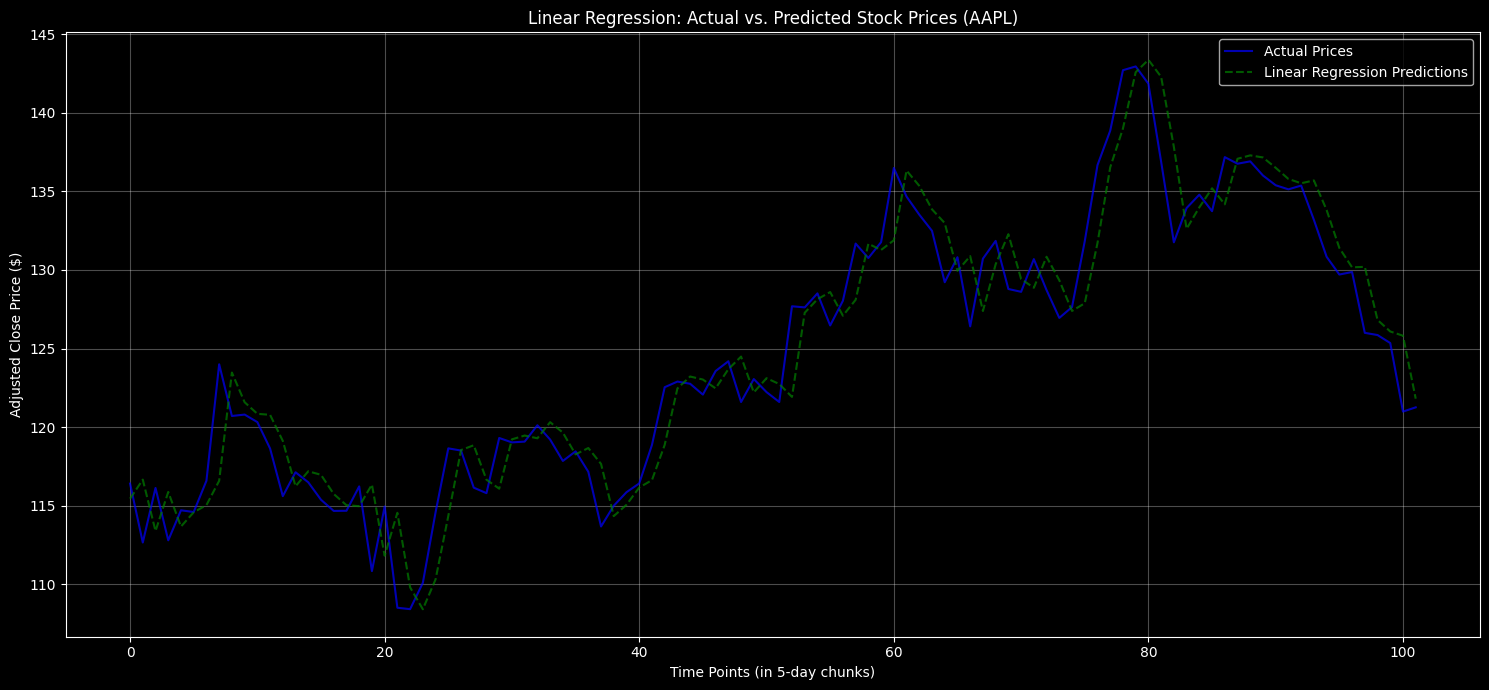

In [53]:
# Visualize Linear Regression Predictions vs Actual
plt.figure(figsize=(15, 7))
plt.plot(Y_test_lr, color='blue', label='Actual Prices', alpha=0.7)
plt.plot(lr_predictions, color='green', linestyle='--', label='Linear Regression Predictions', alpha=0.7)
plt.title('Linear Regression: Actual vs. Predicted Stock Prices (AAPL)')
plt.xlabel('Time Points (in 5-day chunks)')
plt.ylabel('Adjusted Close Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [54]:
# Save Linear Regression Model
import joblib
joblib.dump(lr_model, '../models/AAPL_linear_regression.joblib')
print("Linear regression model saved as '../models/AAPL_linear_regression.joblib'")


Linear regression model saved as '../models/AAPL_linear_regression.joblib'


In [55]:
# Linear Regression for TSLA, GOOG, MSFT, AMZN
from sklearn.linear_model import LinearRegression
import joblib

def train_and_save_linear_regression(data, ticker, window_size=5):
    prices = data['Adj. Close'].values
    X_lr = []
    Y_lr = []
    for i in range(len(prices) - window_size):
        X_lr.append(prices[i:i+window_size])
        Y_lr.append(prices[i+window_size])
    X_lr = np.array(X_lr)
    Y_lr = np.array(Y_lr)
    dates = data['Date'].values[window_size:]
    split_date = pd.to_datetime('2020-10-01')
    train_idx = dates < split_date
    test_idx = dates >= split_date
    X_train_lr = X_lr[train_idx]
    Y_train_lr = Y_lr[train_idx]
    X_test_lr = X_lr[test_idx]
    Y_test_lr = Y_lr[test_idx]
    lr_model = LinearRegression()
    lr_model.fit(X_train_lr, Y_train_lr)
    joblib.dump(lr_model, f'../models/{ticker}_linear_regression.joblib')
    print(f"{ticker} linear regression model saved as '../models/{ticker}_linear_regression.joblib'")

# Ensure date column is datetime
for df in [TSLA, GOOG, MSFT, AMZN]:
    df['Date'] = pd.to_datetime(df['Date'])

train_and_save_linear_regression(TSLA, 'TSLA')
train_and_save_linear_regression(GOOG, 'GOOG')
train_and_save_linear_regression(MSFT, 'MSFT')
train_and_save_linear_regression(AMZN, 'AMZN')


TSLA linear regression model saved as '../models/TSLA_linear_regression.joblib'
GOOG linear regression model saved as '../models/GOOG_linear_regression.joblib'
MSFT linear regression model saved as '../models/MSFT_linear_regression.joblib'
AMZN linear regression model saved as '../models/AMZN_linear_regression.joblib'


TSLA linear regression model saved as '../models/TSLA_linear_regression.joblib'

Linear Regression - Test Set Evaluation for TSLA
Root Mean Squared Error (RMSE): 24.5268
Mean Absolute Error (MAE):      18.2628
R² Score:                        0.9790


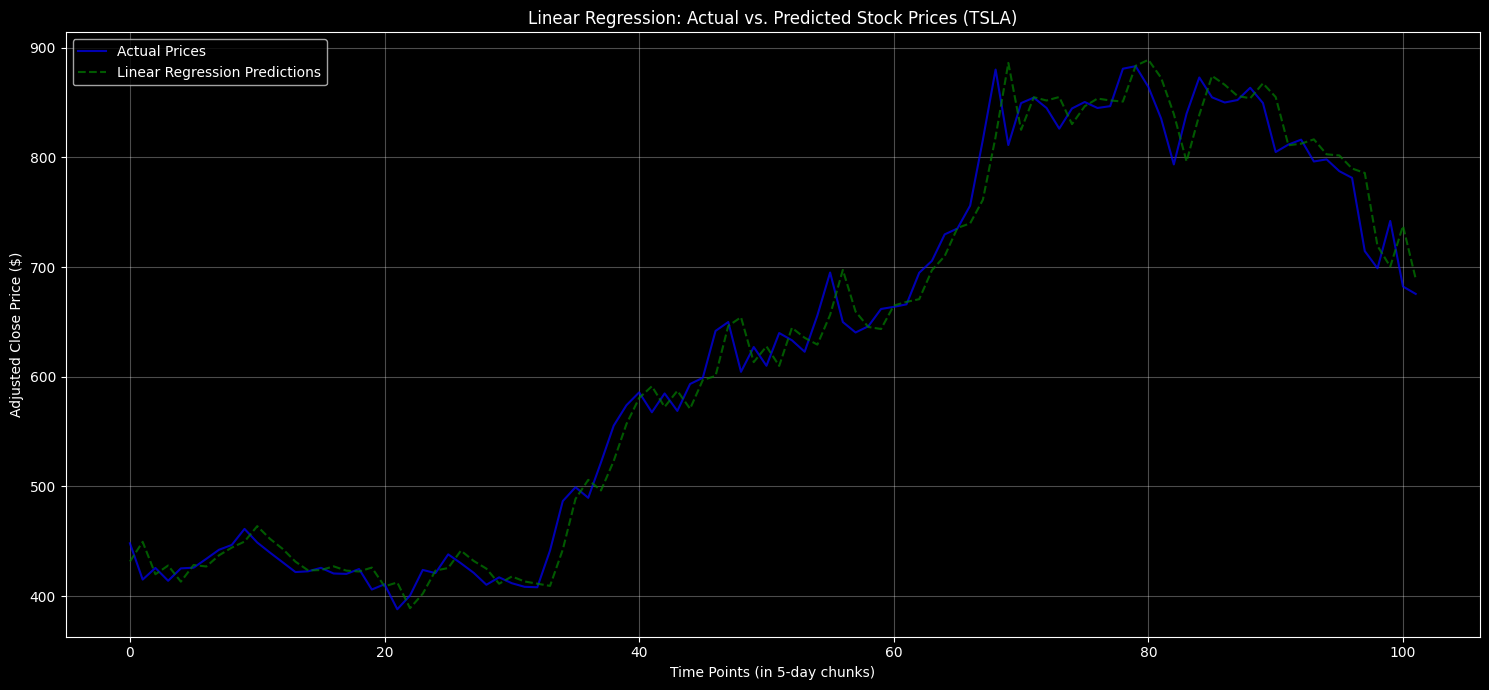

GOOG linear regression model saved as '../models/GOOG_linear_regression.joblib'

Linear Regression - Test Set Evaluation for GOOG
Root Mean Squared Error (RMSE): 33.7577
Mean Absolute Error (MAE):      23.6188
R² Score:                        0.9623


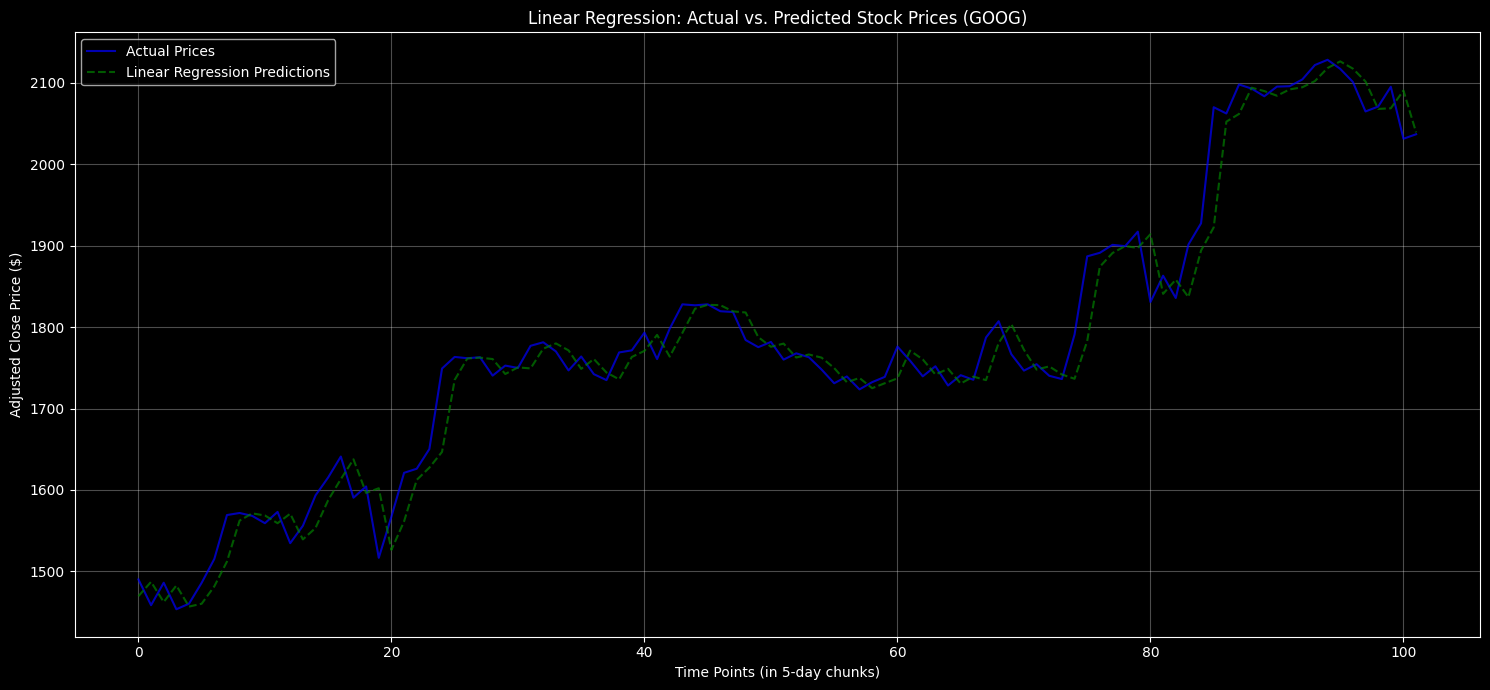

MSFT linear regression model saved as '../models/MSFT_linear_regression.joblib'

Linear Regression - Test Set Evaluation for MSFT
Root Mean Squared Error (RMSE): 3.5869
Mean Absolute Error (MAE):      2.6642
R² Score:                        0.8998


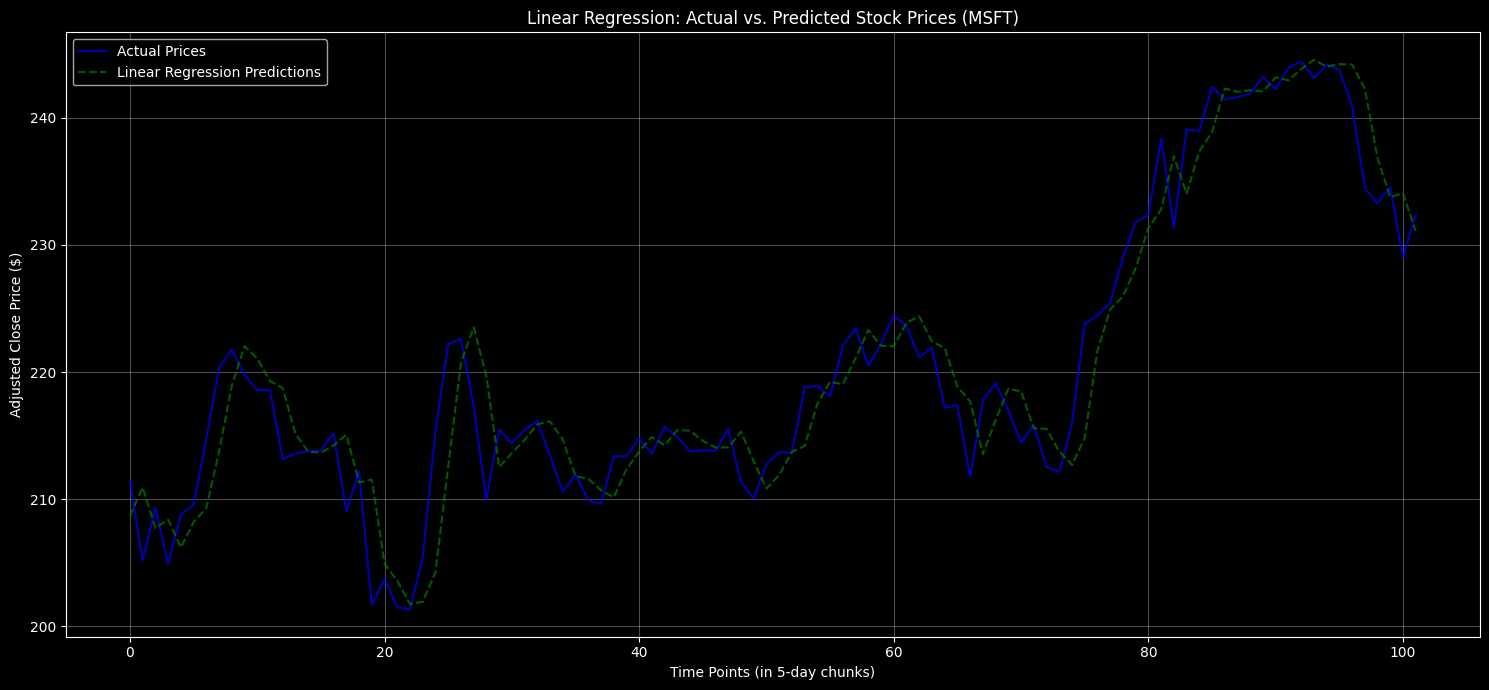

AMZN linear regression model saved as '../models/AMZN_linear_regression.joblib'

Linear Regression - Test Set Evaluation for AMZN
Root Mean Squared Error (RMSE): 62.5604
Mean Absolute Error (MAE):      46.1805
R² Score:                        0.4997


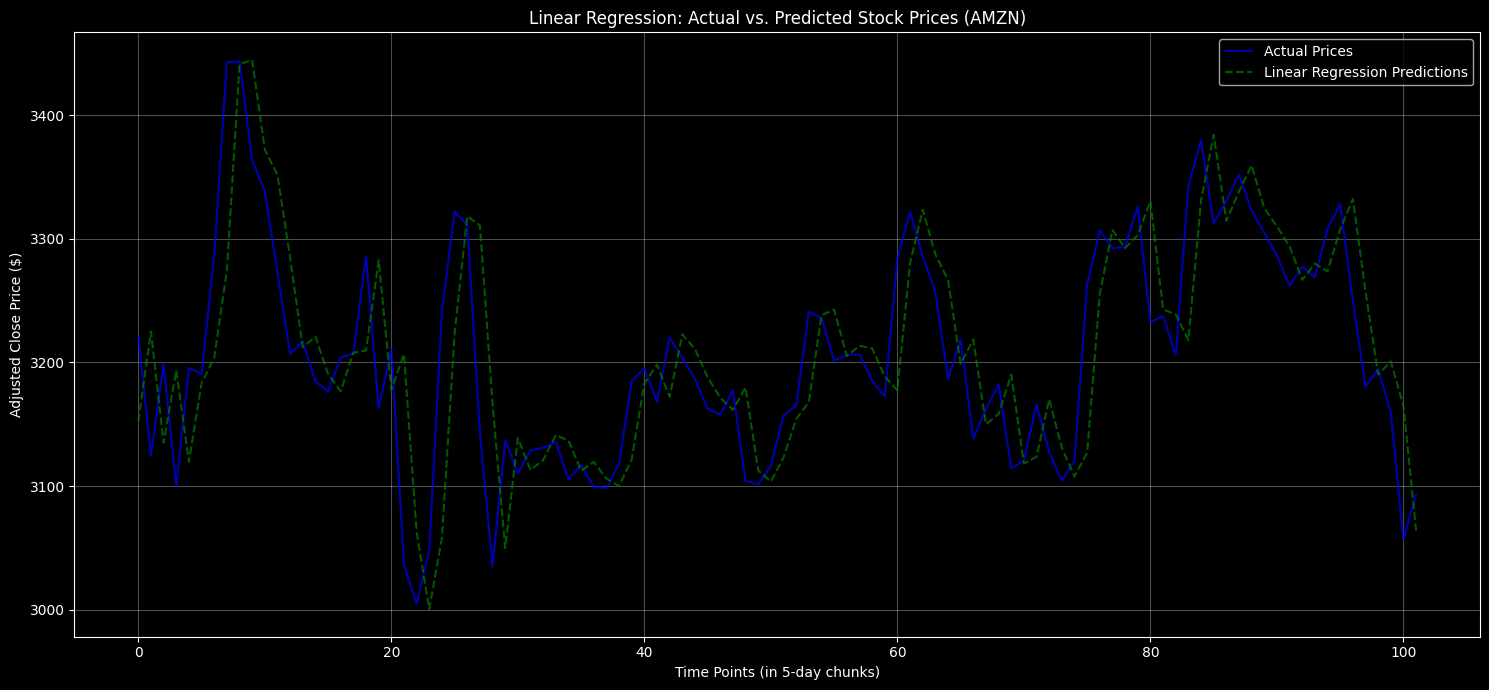

In [56]:
# Independent Linear Regression for TSLA, GOOG, MSFT, AMZN
from sklearn.linear_model import LinearRegression
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def train_evaluate_save_linear_regression(data, ticker, window_size=5):
    prices = data['Adj. Close'].values
    X_lr = []
    Y_lr = []
    for i in range(len(prices) - window_size):
        X_lr.append(prices[i:i+window_size])
        Y_lr.append(prices[i+window_size])
    X_lr = np.array(X_lr)
    Y_lr = np.array(Y_lr)
    dates = data['Date'].values[window_size:]
    split_date = pd.to_datetime('2020-10-01')
    train_idx = dates < split_date
    test_idx = dates >= split_date
    X_train_lr = X_lr[train_idx]
    Y_train_lr = Y_lr[train_idx]
    X_test_lr = X_lr[test_idx]
    Y_test_lr = Y_lr[test_idx]
    lr_model = LinearRegression()
    lr_model.fit(X_train_lr, Y_train_lr)
    joblib.dump(lr_model, f'../models/{ticker}_linear_regression.joblib')
    print(f"{ticker} linear regression model saved as '../models/{ticker}_linear_regression.joblib'")
    # Predict and evaluate
    lr_predictions = lr_model.predict(X_test_lr)
    lr_mse = mean_squared_error(Y_test_lr, lr_predictions)
    lr_rmse = np.sqrt(lr_mse)
    lr_mae = mean_absolute_error(Y_test_lr, lr_predictions)
    lr_r2 = r2_score(Y_test_lr, lr_predictions)
    print(f"\n{'='*50}")
    print(f"Linear Regression - Test Set Evaluation for {ticker}")
    print(f"{'='*50}")
    print(f"Root Mean Squared Error (RMSE): {lr_rmse:.4f}")
    print(f"Mean Absolute Error (MAE):      {lr_mae:.4f}")
    print(f"R² Score:                        {lr_r2:.4f}")
    print(f"{'='*50}")
    # Visualization
    plt.figure(figsize=(15, 7))
    plt.plot(Y_test_lr, color='blue', label='Actual Prices', alpha=0.7)
    plt.plot(lr_predictions, color='green', linestyle='--', label='Linear Regression Predictions', alpha=0.7)
    plt.title(f'Linear Regression: Actual vs. Predicted Stock Prices ({ticker})')
    plt.xlabel('Time Points (in 5-day chunks)')
    plt.ylabel('Adjusted Close Price ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Ensure date column is datetime
for df in [TSLA, GOOG, MSFT, AMZN]:
    df['Date'] = pd.to_datetime(df['Date'])

train_evaluate_save_linear_regression(TSLA, 'TSLA')
train_evaluate_save_linear_regression(GOOG, 'GOOG')
train_evaluate_save_linear_regression(MSFT, 'MSFT')
train_evaluate_save_linear_regression(AMZN, 'AMZN')


In [ ]:
import joblib
import numpy as np

# Example: Predict next price for TSLA, GOOG, MSFT, AMZN
# Assume you have a numpy array of the last 5 days' prices for each stock

# Replace these with your real incoming data
last_5_tsla = np.array([price1, price2, price3, price4, price5]).reshape(1, -1)
last_5_goog = np.array([price1, price2, price3, price4, price5]).reshape(1, -1)
last_5_msft = np.array([price1, price2, price3, price4, price5]).reshape(1, -1)
last_5_amzn = np.array([price1, price2, price3, price4, price5]).reshape(1, -1)

# Load models
tsla_model = joblib.load('../models/TSLA_linear_regression.joblib')
goog_model = joblib.load('../models/GOOG_linear_regression.joblib')
msft_model = joblib.load('../models/MSFT_linear_regression.joblib')
amzn_model = joblib.load('../models/AMZN_linear_regression.joblib')

# Predict next price
tsla_next = tsla_model.predict(last_5_tsla)[0]
goog_next = goog_model.predict(last_5_goog)[0]
msft_next = msft_model.predict(last_5_msft)[0]
amzn_next = amzn_model.predict(last_5_amzn)[0]

print(f"TSLA next predicted price: {tsla_next:.2f}")
print(f"GOOG next predicted price: {goog_next:.2f}")
print(f"MSFT next predicted price: {msft_next:.2f}")
print(f"AMZN next predicted price: {amzn_next:.2f}")
